In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import random

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import *
from utils import *
#get_device, get_noise, init_weights, plot_tensor_images, plot_losses, Positive, RevKlActivation
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist
from torch.utils.tensorboard import SummaryWriter
from fid import InceptionV3, calculate_frechet

In [3]:
# create dataloader
batch_size = 128
device = get_device()

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

Time is 0.017674684524536133 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


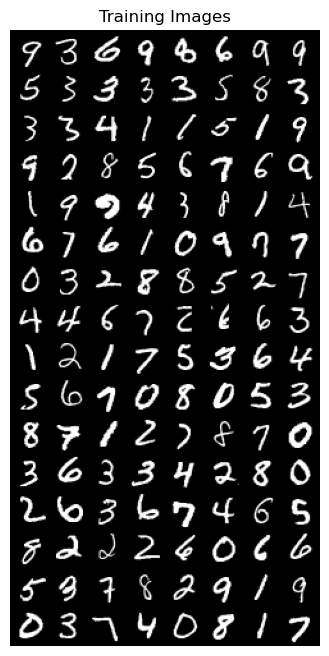

In [4]:
start = time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [5]:
latent_dim = 100
latent_dim_bhs = 28*28
batch_size_bhs = 128
test_noise = get_noise(25, latent_dim, device)
test_noise_bhs = get_noise(25, latent_dim_bhs, device)

## First I train a Wasserstein GAN

In [32]:
torch.manual_seed(96)
random.seed(96)

training_params = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=50,
                                 num_dis_updates=4,
                                 num_gen_updates=3,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [33]:
generator_wasserstein = GeneratorWassersteinMnist(latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinMnist(28*28).apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device=device)

In [71]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 16.481350	Loss_C : -1.697189	Loss_G : -3.929598	
Total_Time : 16.482351
Loss_C : -1.697189
Loss_G : -3.929598
Loss_C_Mean : -1.831544
Loss_G_Mean : -1.019035

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 15.885262	Loss_C : -1.110030	Loss_G : -5.992853	
Total_Time : 15.887264
Loss_C : -1.110030
Loss_G : -5.992853
Loss_C_Mean : -1.394962
Loss_G_Mean : -4.715954

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 15.783746	Loss_C : -1.057435	Loss_G : -5.359712	
Total_Time : 15.785748
Loss_C : -1.057435
Loss_G : -5.359712
Loss_C_Mean : -1.065499
Loss_G_Mean : -5.188088

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 15.956887	Loss_C : -0.936879	Loss_G : -5.641266	
Total_Time : 15.957887
Loss_C : -0.936879
Loss_G : -5.6412

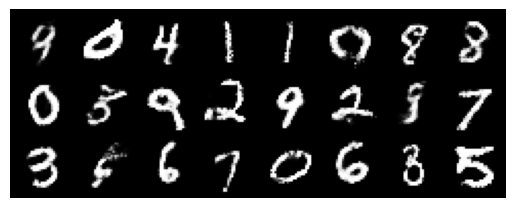

In [98]:
# show generated images
torch.manual_seed(12)
test_noise = get_noise(25, latent_dim, device)
generated_images_wasserstein = trained_wgan.generator(test_noise)
plot_tensor_images(generated_images_wasserstein, num_images=24)

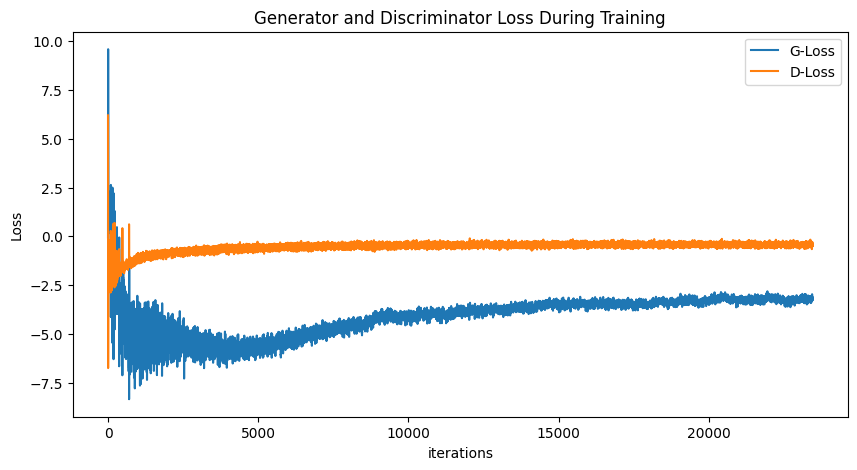

In [75]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

Save model Parameters

In [237]:
torch.save(generator_wasserstein.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/WS_Gen.pt")
torch.save(discriminator_wasserstein.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/WS_Disc.pt")

## BHS Gan
$f^*(x) = 2(-1+\sqrt{1+x})\exp(\sqrt{1+x})$

In [34]:
torch.manual_seed(96)
random.seed(96)

training_params_bhs = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=50, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_bhs = GeneratorBhsMnist(latent_dim_bhs)
discriminator_bhs = DiscriminatorBhsMnist(Positive, 28*28)
trainer_bhs = Trainer(training_params_bhs, generator_bhs, discriminator_bhs, device=device)

In [77]:
trained_bhsgan = trainer_bhs.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 14.679633	Loss_C : 0.033616	Loss_G : -0.103953		
Total_Time : 14.680635
Loss_C : 0.033616
Loss_G : -0.103953
Loss_C_Mean : 0.023251
Loss_G_Mean : -0.188927

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 14.462718	Loss_C : 0.063386	Loss_G : -0.106358		
Total_Time : 14.463719
Loss_C : 0.063386
Loss_G : -0.106358
Loss_C_Mean : 0.020632
Loss_G_Mean : -0.083835

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 14.757414	Loss_C : 0.028972	Loss_G : -0.076717		
Total_Time : 14.758415
Loss_C : 0.028972
Loss_G : -0.076717
Loss_C_Mean : 0.009469
Loss_G_Mean : -0.067372

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 14.457139	Loss_C : 0.004893	Loss_G : -0.045236		
Total_Time : 14.457139
Loss_C : 0.004893
Loss_G : -0.045236
Loss

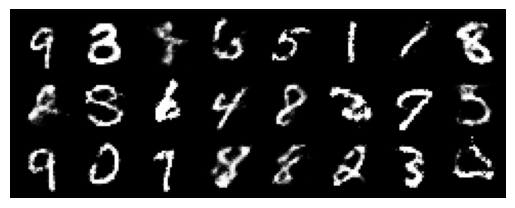

In [97]:
# show generated images
torch.manual_seed(12)
test_noise_bhs = get_noise(24, latent_dim_bhs, device)
generated_images_bhs = trained_bhsgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_bhs, num_images=24)

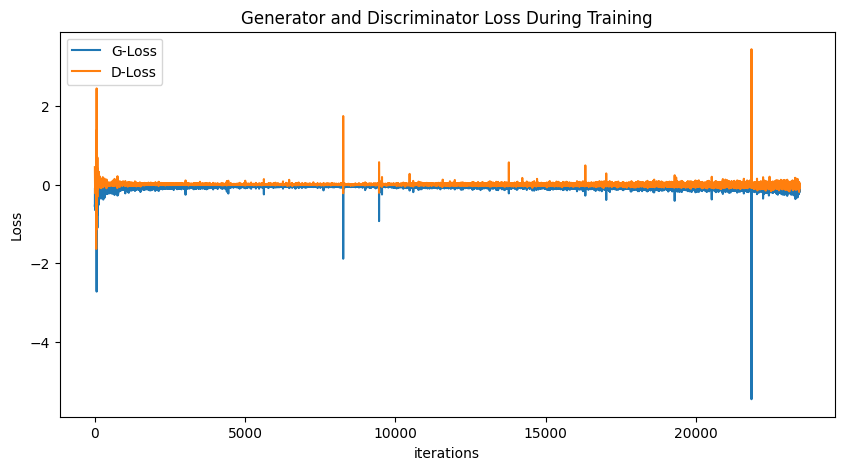

In [80]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

In [238]:
torch.save(generator_bhs.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/BHS_Gen.pt")
torch.save(discriminator_bhs.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/BHS_Disc.pt")

## KL GAN
$f^*(x) = \exp(x-1)$


In [8]:
torch.manual_seed(96)
random.seed(96)

training_params_KL = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=50, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_KL = GeneratorBhsMnist(latent_dim)
discriminator_KL = DiscriminatorBhsMnist(nn.Identity, 28*28)
trainer_kl = Trainer(training_params_KL, generator_KL, discriminator_KL, device=device)

In [9]:
trained_klgan = trainer_kl.train_gan(dataloader, get_dis_loss_kl, get_gen_loss_kl, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 26.447541	Loss_C : -0.088526	Loss_G : -0.884085	
Total_Time : 26.449938
Loss_C : -0.088526
Loss_G : -0.884085
Loss_C_Mean : -0.562245
Loss_G_Mean : -0.755222

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 28.065738	Loss_C : -0.191886	Loss_G : -1.111045	
Total_Time : 28.065738
Loss_C : -0.191886
Loss_G : -1.111045
Loss_C_Mean : -0.265455
Loss_G_Mean : -0.947829

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 28.015960	Loss_C : -0.242541	Loss_G : -1.029647	
Total_Time : 28.015960
Loss_C : -0.242541
Loss_G : -1.029647
Loss_C_Mean : -0.275943
Loss_G_Mean : -1.046114

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 27.215694	Loss_C : -0.693579	Loss_G : -0.914956	
Total_Time : 27.215694
Loss_C : -0.693579
Loss_G : -0.9149

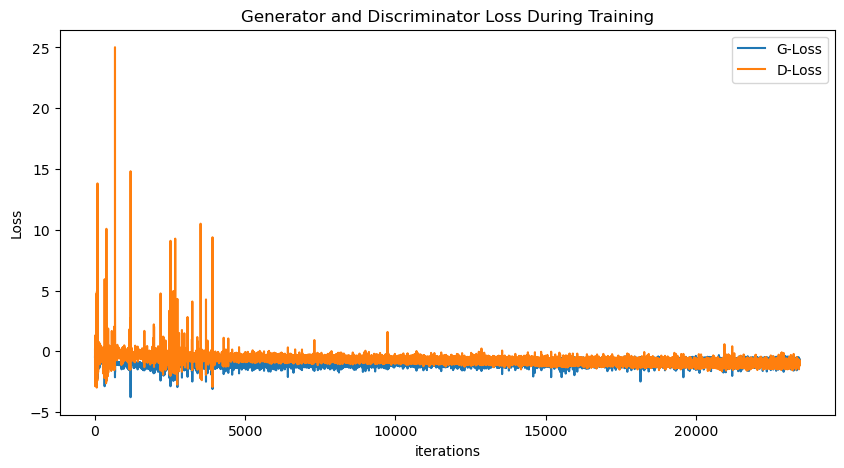

In [10]:
plot_losses(trained_klgan.generator_losses, trained_klgan.discriminator_losses)

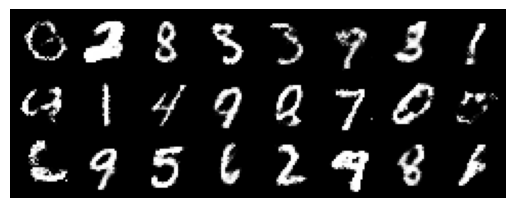

In [11]:
torch.manual_seed(12)
test_noise = get_noise(24, latent_dim, device)
generated_images_kl = trained_klgan.generator(test_noise)
plot_tensor_images(generated_images_kl, num_images=25)

In [53]:
torch.save(generator_KL.state_dict(), "State_Dicts/KL_Gen.pt")
torch.save(discriminator_KL.state_dict(), "State_Dicts/KL_Disc.pt")

## Rev KL GAN
$f^*(x) = -1 - \log(x)$


In [12]:
torch.manual_seed(96)
random.seed(96)

training_params_RKL = TrainingParams(lr_dis=0.0002,
                                     lr_gen=0.0002,
                                     num_epochs=50,
                                     num_dis_updates=4,
                                     num_gen_updates=3,
                                     beta_1=0.5,
                                     batch_size=batch_size_bhs)
generator_RKL = GeneratorBhsMnist(latent_dim)
discriminator_RKL = DiscriminatorBhsMnist(RevKlActivation, 28 * 28)
trainer_rkl = Trainer(training_params_RKL, generator_RKL, discriminator_RKL, device=device)


In [13]:
trained_rklgan = trainer_rkl.train_gan(dataloader, get_dis_loss_rkl, get_gen_loss_rkl, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 30.680504	Loss_C : 0.100546	Loss_G : 1.216549		
Total_Time : 30.680504
Loss_C : 0.100546
Loss_G : 1.216549
Loss_C_Mean : -0.286530
Loss_G_Mean : 1.415636

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 26.683173	Loss_C : 0.004821	Loss_G : 0.941370		
Total_Time : 26.683173
Loss_C : 0.004821
Loss_G : 0.941370
Loss_C_Mean : 0.017876
Loss_G_Mean : 1.268301

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 30.130791	Loss_C : 1.358803	Loss_G : 1.273260		
Total_Time : 30.147578
Loss_C : 1.358803
Loss_G : 1.273260
Loss_C_Mean : -0.870384
Loss_G_Mean : 1.910974

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 30.996797	Loss_C : -2.378485	Loss_G : 3.174416	
Total_Time : 30.996797
Loss_C : -2.378485
Loss_G : 3.174416
Loss_C_Mean 

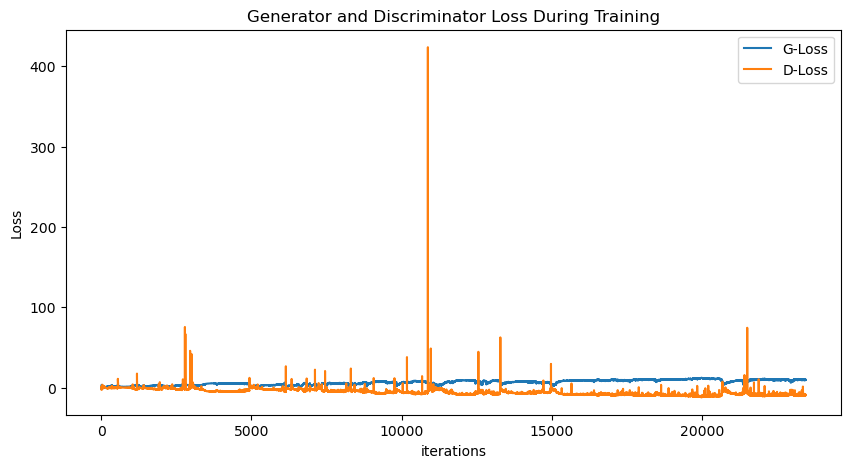

In [14]:
plot_losses(trained_rklgan.generator_losses, trained_rklgan.discriminator_losses)

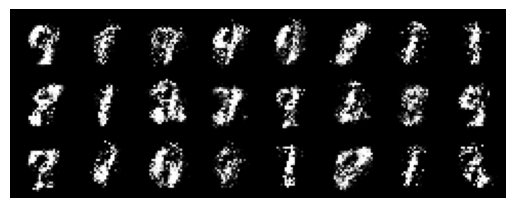

In [15]:
torch.manual_seed(12)
test_noise = get_noise(24, latent_dim, device)
generated_images_rkl = trained_rklgan.generator(test_noise)
plot_tensor_images(generated_images_rkl, num_images=25)

In [52]:
torch.save(generator_RKL.state_dict(), "State_Dicts/RKL_Gen.pt")
torch.save(discriminator_RKL.state_dict(), "State_Dicts/RKL_Disc.pt")

## Pearson GAN
$f^*(x) = \frac{1}{4} x^2 + x$

In [16]:
torch.manual_seed(96)
random.seed(96)

training_params_pgan = TrainingParams(lr_dis=0.0002,
                                      lr_gen=0.002,
                                      num_epochs=50,
                                      num_dis_updates=4,
                                      num_gen_updates=3,
                                      beta_1=0.5,
                                      batch_size=batch_size_bhs)
generator_pgan = GeneratorBhsMnist(latent_dim)
discriminator_pgan = DiscriminatorBhsMnist(nn.Identity,28 * 28)
trainer_kl = Trainer(training_params_pgan, generator_pgan, discriminator_pgan, device=device)


In [17]:
trained_pgan = trainer_kl.train_gan(dataloader, get_dis_loss_p, get_gen_loss_p, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 28.532981	Loss_C : 0.053371	Loss_G : -0.180212		
Total_Time : 28.532981
Loss_C : 0.053371
Loss_G : -0.180212
Loss_C_Mean : -0.293047
Loss_G_Mean : 0.066201

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 28.365056	Loss_C : -0.241898	Loss_G : 0.076605		
Total_Time : 28.380678
Loss_C : -0.241898
Loss_G : 0.076605
Loss_C_Mean : -0.072566
Loss_G_Mean : 0.017040

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 28.265498	Loss_C : -0.025490	Loss_G : 0.055187		
Total_Time : 28.265498
Loss_C : -0.025490
Loss_G : 0.055187
Loss_C_Mean : -0.045814
Loss_G_Mean : 0.034306

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 28.332940	Loss_C : -0.006076	Loss_G : 0.059628		
Total_Time : 28.332940
Loss_C : -0.006076
Loss_G : 0.059628
Loss

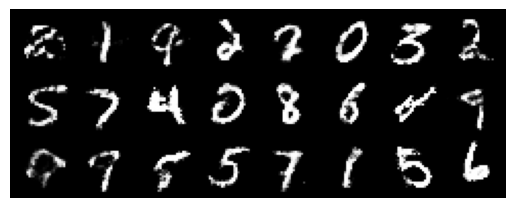

In [18]:
torch.manual_seed(12)
test_noise = get_noise(24, latent_dim, device)

generated_images_pgan = trained_pgan.generator(test_noise)
plot_tensor_images(generated_images_pgan, num_images=24)


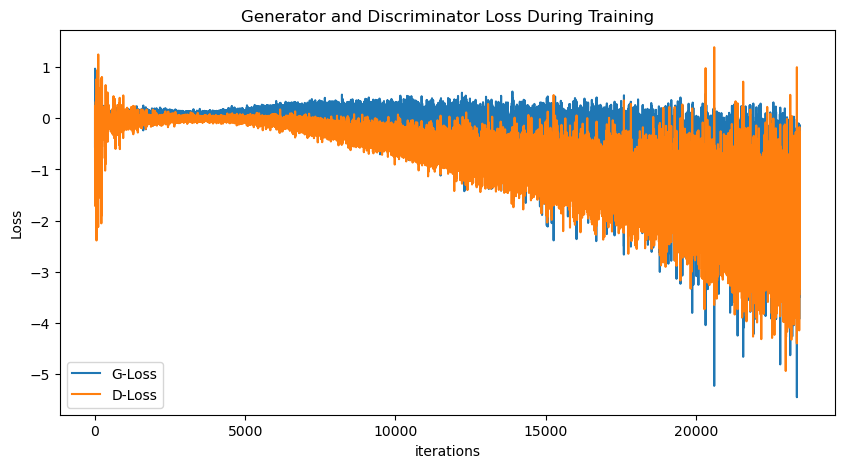

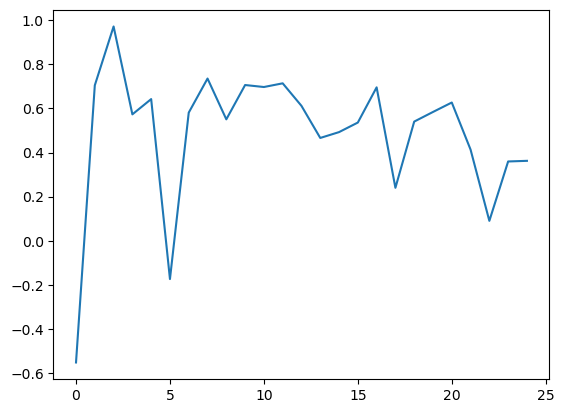

In [19]:
plot_losses(trained_pgan.generator_losses, trained_pgan.discriminator_losses)
plt.plot(trained_pgan.generator_losses[0:25])

In [51]:
torch.save(generator_pgan.state_dict(), "State_Dicts/P_Gen.pt")
torch.save(discriminator_pgan.state_dict(), "State_Dicts/P_Disc.pt")

## GAN GAN
$f^*(x) = -\log(1-\exp(x))$

In [28]:
torch.manual_seed(95)
random.seed(95)

training_params_GAN = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=30, num_dis_updates=4, num_gen_updates=3,
                                    beta_1=0.5, batch_size=batch_size_bhs)
generator_GAN = GeneratorBhsMnist(latent_dim)
discriminator_GAN = DiscriminatorBhsMnist(GanGanActivation, 28 * 28)
trainer_gan = Trainer(training_params_GAN, generator_GAN, discriminator_GAN, device=device)

In [29]:
trained_gan = trainer_gan.train_gan(dataloader, get_dis_loss_gan, get_gen_loss_gan, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/30 Total Steps:469poch_Run_Time: 28.900615	Loss_C : 0.375158	Loss_G : -0.142040	
Total_Time : 28.900615
Loss_C : 0.375158
Loss_G : -0.142040
Loss_C_Mean : 0.801649
Loss_G_Mean : -0.338789

----------------------------------------------

Epoch 2 start training...
Epoch: 2/30 Total Steps:938poch_Run_Time: 28.878561	Loss_C : 0.704974	Loss_G : -0.279412	
Total_Time : 28.878561
Loss_C : 0.704974
Loss_G : -0.279412
Loss_C_Mean : 0.805969
Loss_G_Mean : -0.295053

----------------------------------------------

Epoch 3 start training...
Epoch: 3/30 Total Steps:1407och_Run_Time: 29.083105	Loss_C : 0.844901	Loss_G : -0.365864	
Total_Time : 29.083105
Loss_C : 0.844901
Loss_G : -0.365864
Loss_C_Mean : 0.892611
Loss_G_Mean : -0.380414

----------------------------------------------

Epoch 4 start training...
Epoch: 4/30 Total Steps:1876och_Run_Time: 26.792281	Loss_C : 1.005131	Loss_G : -0.448933	
Total_Time : 26.792281
Loss_C : 1.005131
Loss_G : -0.448933
Loss_C_M

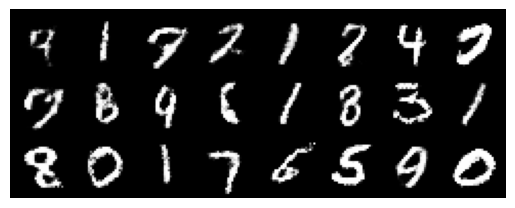

In [30]:
torch.manual_seed(4)
test_noise = get_noise(24, latent_dim, device)
generated_images_gan = trained_gan.generator(test_noise)
plot_tensor_images(generated_images_gan, num_images=24)

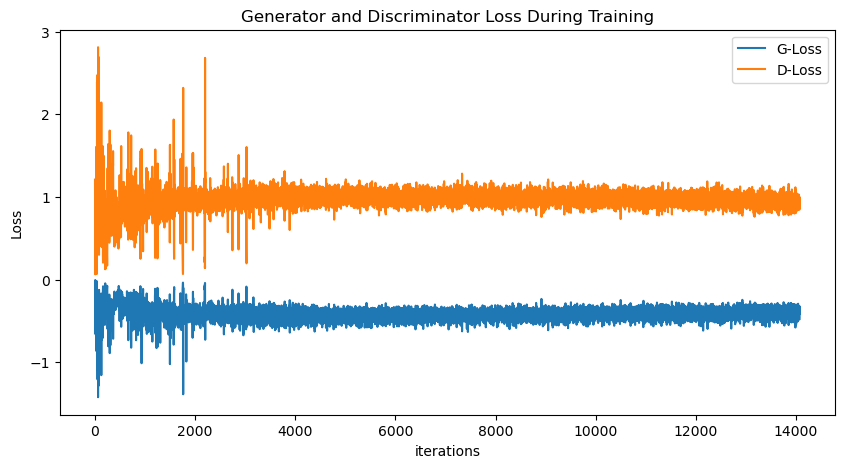

In [31]:
plot_losses(trained_gan.generator_losses, trained_gan.discriminator_losses)

In [41]:
torch.save(generator_GAN.state_dict(), "State_Dicts/GAN_Gen.pt")
torch.save(discriminator_GAN.state_dict(), "State_Dicts/GAN_Disc.pt")


## IPM BHS GAN

In [226]:
torch.manual_seed(96)
random.seed(96)

training_params_ipm = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=50, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size)
generator_ipm = GeneratorIpmMnist(latent_dim).apply(init_weights)
discriminator_ipm = DiscriminatorIpmMnist(28*28).apply(init_weights)
trainer_ipm = Trainer(training_params_ipm, generator_ipm, discriminator_ipm, device=device)

In [227]:
# training loop
trained_ipmgan = trainer_ipm.train_gan(dataloader, get_dis_loss_ipm, get_gen_loss_ipm, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/50 Total Steps:469poch_Run_Time: 13.806820	Loss_C : -29.872018	Loss_G : -6.364963		
Total_Time : 13.806820
Loss_C : -29.872018
Loss_G : -6.364963
Loss_C_Mean : -18.869481
Loss_G_Mean : -2.002932

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:938poch_Run_Time: 13.669815	Loss_C : -27.949175	Loss_G : -33.550549	
Total_Time : 13.670816
Loss_C : -27.949175
Loss_G : -33.550549
Loss_C_Mean : -16.570898
Loss_G_Mean : -44.459380

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1407och_Run_Time: 13.429141	Loss_C : -7.566180	Loss_G : -60.432163		
Total_Time : 13.429141
Loss_C : -7.566180
Loss_G : -60.432163
Loss_C_Mean : -10.586425
Loss_G_Mean : -59.355927

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1876och_Run_Time: 14.139705	Loss_C : -9.696076	Loss_G : -104.303329		
Total_Time : 14.140705
Loss_C : -9.69607

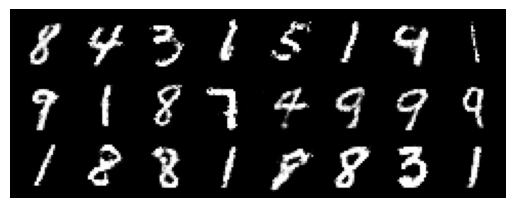

In [228]:
# show generated images
torch.manual_seed(14)
test_noise = get_noise(24, latent_dim, device)
generated_images_ipm = trained_ipmgan.generator(test_noise)
plot_tensor_images(generated_images_ipm, num_images=24)

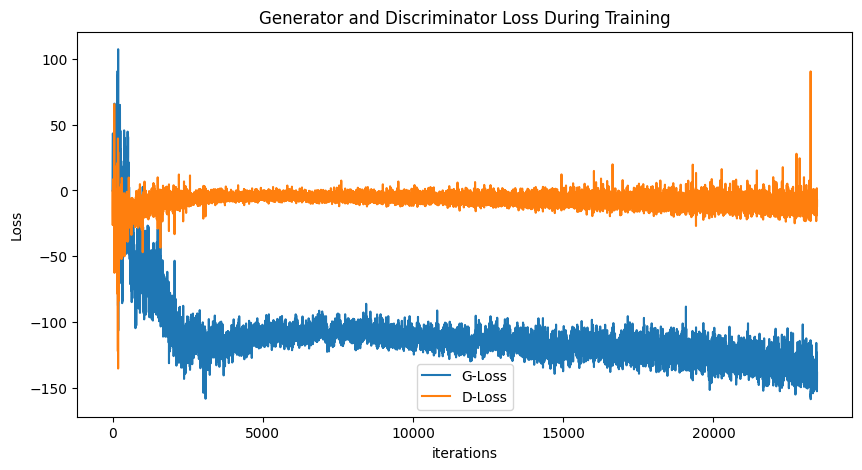

In [229]:
# plot losses
plot_losses(trained_ipmgan.generator_losses, trained_ipmgan.discriminator_losses)

In [ ]:
torch.save(generator_i.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/RKL_Gen.pt")
torch.save(discriminator_RKL.state_dict(), "C:/Users/Rick/Desktop/bhsgan/State_Dicts/RKL_Disc.pt")

### Evaluate with FID

In [38]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx], normalize_input=False)
model=model.cuda()

C:\Users\fottneal\Miniconda3\envs\bhsgan\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fottneal\Miniconda3\envs\bhsgan\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
# sample onr batch of real data
real_images = iter(dataloader)._next_data()[0]
# generate noise
fid_noise = get_noise(128, latent_dim, device)
fid_noise_bhs = get_noise(128, latent_dim_bhs, device)

In [35]:
# get generators
generator_wasserstein.load_state_dict(torch.load("State_Dicts/WS_Gen.pt"))
generator_bhs.load_state_dict(torch.load("State_Dicts/BHS_Gen.pt"))

<All keys matched successfully>

In [42]:
# generate images
generated_images_wasserstein = generator_wasserstein(fid_noise)
generated_images_bhs = generator_bhs(fid_noise_bhs)
generated_images_kl = trained_klgan.generator(fid_noise)
generated_images_rvkl = trained_rklgan.generator(fid_noise)
generated_images_gan = trained_gan.generator(fid_noise)
generated_images_pearson = trained_pgan.generator(fid_noise)

In [50]:
fid_wasserstein = calculate_frechet(real_images , generated_images_wasserstein, model)
fid_wasserstein

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[128, 1, 299, 299] to have 3 channels, but got 1 channels instead

In [ ]:
fid_bhs = calculate_frechet(real_images , generated_images_bhs, model)
fid_bhs

In [ ]:
fid_kl = calculate_frechet(real_images , generated_images_kl, model)
fid_kl

In [ ]:
fid_rvkl = calculate_frechet(real_images , generated_images_rvkl, model)
fid_rvkl

In [ ]:
fid_gan = calculate_frechet(real_images , generated_images_gan, model)
fid_gan

In [ ]:
fid_pearson = calculate_frechet(real_images , generated_images_pearson, model)
fid_pearson